# 2D optimisation with precomputed multi-task initialisation data

This notebook shows how to use data collected in one optimisation task to warm start optimisation in another task. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from boss.bo.bo_main import BOMain
from utils import load_model

In [3]:
seed = 221220
num_init = 5
num_iter = 20
acqfn_name = 'elcb'

optimisation task 0:

In [4]:
unknown_model_0 = load_model('../models/model_2D_E0.npz')
bounds = [[-50.0, 310.0]] * 2
yrange = [0, 20]

In [5]:
def f(x):
    return unknown_model_0.predict(np.atleast_2d(x))[0]

plot:

In [6]:
xp = np.linspace(-50, 310, 361)
x1, x2 = np.meshgrid(xp, xp)
levels = 25

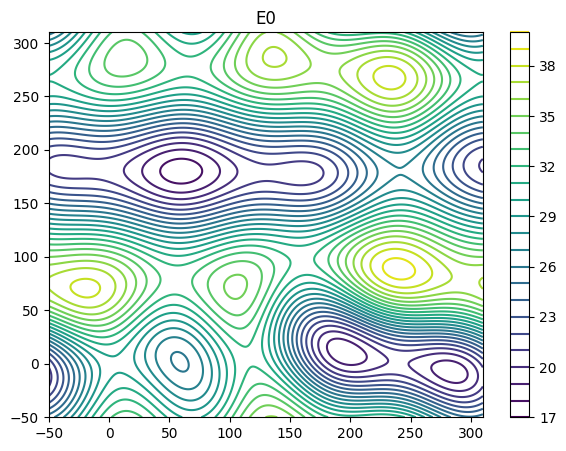

In [7]:
plt.figure(figsize=(7, 5))
yp = f(np.column_stack((x1.ravel(), x2.ravel())))
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E0');

run optimisation:

In [8]:
bo_1 = BOMain(
    f, 
    bounds,
    yrange=yrange,
    kernel='stdp',
    initpts=num_init,
    iterpts=num_iter,
    acqfn_name=acqfn_name,
    seed=seed,
    outfile='boss_2D_E0.out',
    rstfile='boss_2D_E0.rst',
)

In [9]:
%time res_1 = bo_1.run()

CPU times: user 17.4 s, sys: 4.45 s, total: 21.8 s
Wall time: 11.5 s


estimated minimum:

In [10]:
res_1.select('x_glmin', -1)

array([ 61.48821176, 181.52346942])

plot:

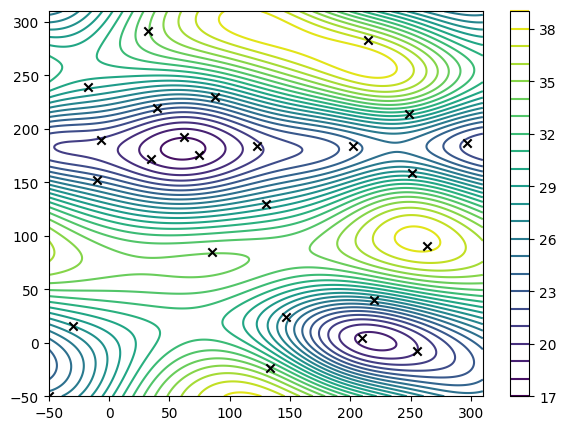

In [11]:
plt.figure(figsize=(7, 5))
yp = bo_1.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_1.model.X[:, 0], bo_1.model.X[:, 1], marker='x', color='k', zorder=10);

model reconstruction:

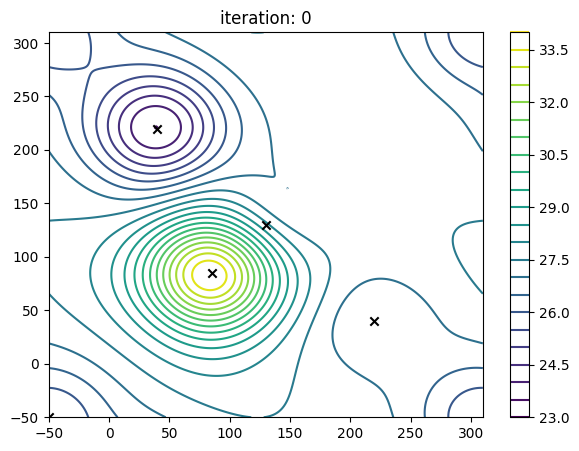

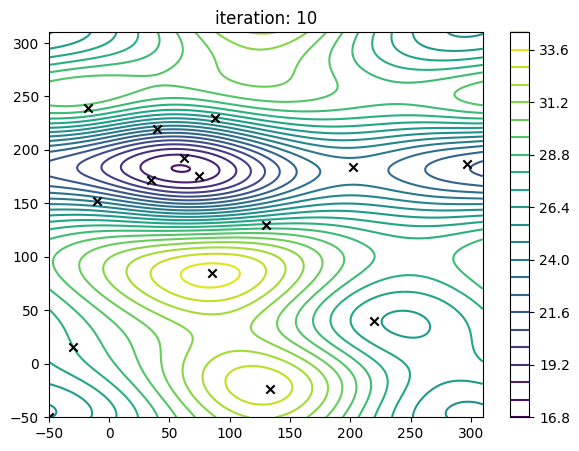

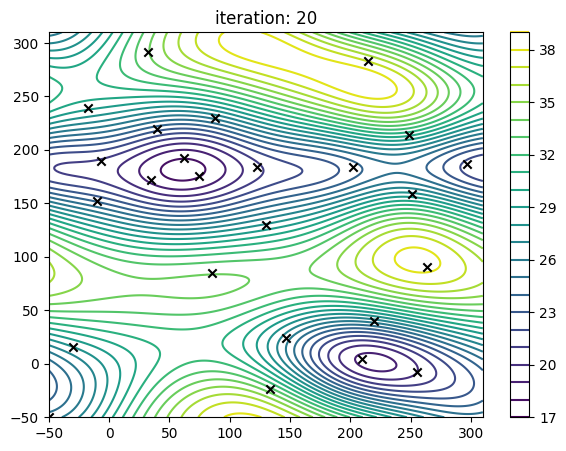

In [12]:
step_size = 10
for itr in np.arange(res_1.num_iters)[::step_size]:
    model_itr = res_1.reconstruct_model(itr)
    plt.figure(figsize=(7, 5))
    yp = model_itr.predict(np.column_stack((x1.ravel(), x2.ravel())))[0]
    cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
    plt.colorbar(cset)
    plt.title('iteration: {}'.format(itr))
    plt.scatter(model_itr.X[:, 0], model_itr.X[:, 1], marker='x', color='k', zorder=10);

optimisation task 1:

In [13]:
unknown_model_1 = load_model('../models/model_2D_E1.npz')
bounds = [[-50.0, 310.0]] * 2
yrange = [0, 1]

In [14]:
def f(x):
    return unknown_model_1.predict(np.atleast_2d(x))[0]

plot:

In [15]:
xp = np.linspace(-50, 310, 361)
x1, x2 = np.meshgrid(xp, xp)
levels = 25

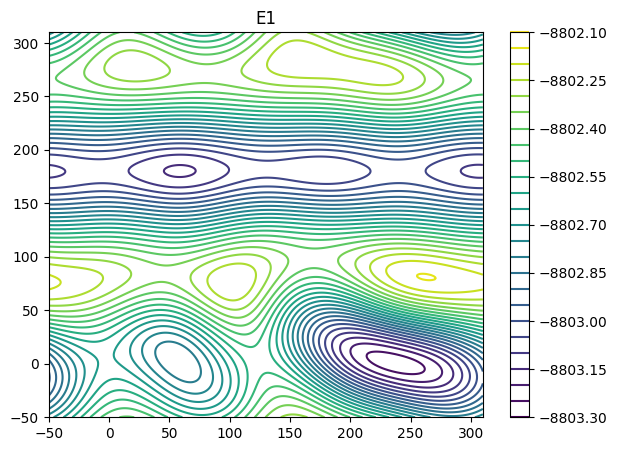

In [16]:
plt.figure(figsize=(7, 5))
yp = f(np.column_stack((x1.ravel(), x2.ravel())))
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E1');

use data collected in the previous optimisation task to warm start optimisation in the new task. in this case the previous acquisitions are available in the optimisation results:

In [17]:
X = res_1["X"]
Y = res_1["Y"]

otherwise we could read the rst output:

In [18]:
import boss.io.parse as parse

In [19]:
data = parse.parse_input_file('boss_2D_E0.rst')

extract previous acquisitions:

In [20]:
dim = len(data["keywords"]["bounds"]) 
X, Y = np.split(data.get("rst_data")[:, :dim + 1], [dim], axis=1)

create initialisation data for the current optimisation task. here we choose `num_init` values from the previous acquisitions:

In [21]:
num_init = min(num_init, len(X))
X_init = X[:num_init]
Y_init = np.full((num_init, 1), np.nan)

multi-task initialisation data:

In [22]:
X_init_multi = np.vstack((np.hstack((X_init, np.full((num_init, 1), 0))), np.hstack((X, np.full((len(X), 1), 1)))))
Y_init_multi = np.vstack((Y_init, Y))

initialise optimisation with `num_tasks = 2` and a user function list:

In [23]:
bo_2 = BOMain(
    [f],
    bounds,
    num_tasks=2,
    yrange=yrange,
    kernel='stdp',
    iterpts=num_iter,
    acqfn_name=acqfn_name,
    seed=seed,
    outfile='warm_start_2D.out',
    rstfile='warm_start_2D.rst',
)

run optimisation with the custom initialisation data:

In [24]:
%time res_2 = bo_2.run(X_init=X_init_multi, Y_init=Y_init_multi)

CPU times: user 46.8 s, sys: 7.29 s, total: 54.1 s
Wall time: 57.2 s


estimated minimum:

In [25]:
res_2.select('x_glmin', -1)

array([236.92014865,   0.89474223,   0.        ])

plot:

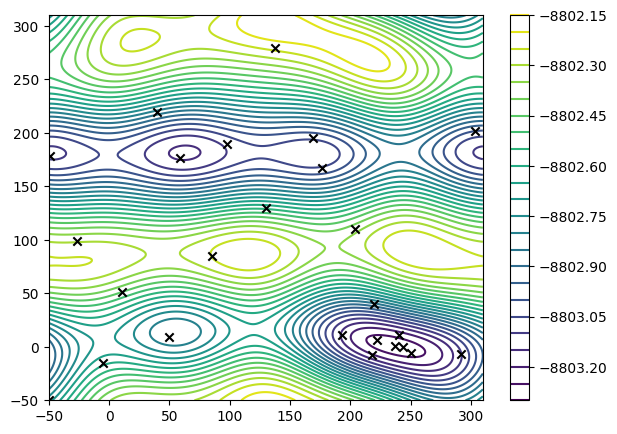

In [26]:
yp = bo_2.model.predict(np.column_stack((x1.ravel(),x2.ravel())), index=0)[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.get_X(index=0)[:,0], bo_2.model.get_X(index=0)[:,1], marker='x', color='k', zorder=10);

model reconstruction:

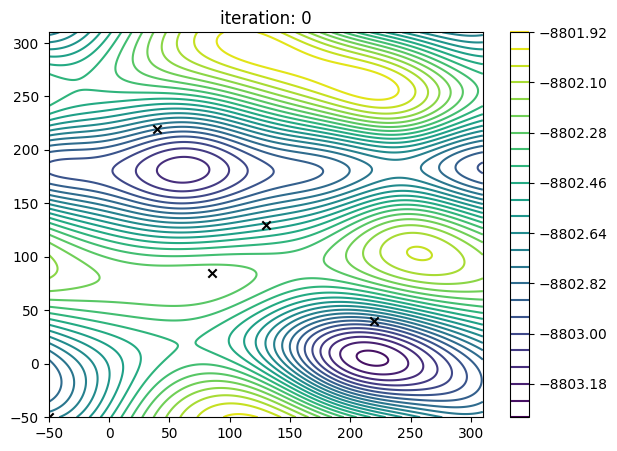

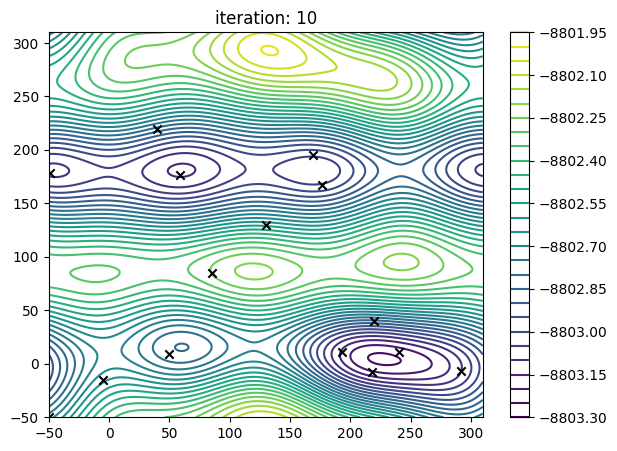

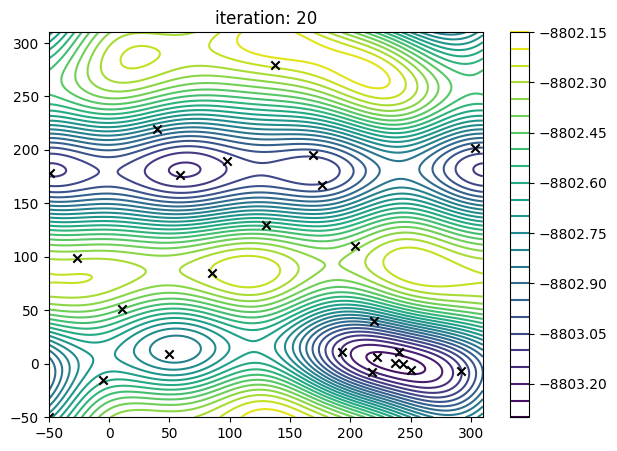

In [27]:
step_size = 10
for itr in np.arange(res_2.num_iters)[::step_size]:
    model_itr = res_2.reconstruct_model(itr)
    plt.figure(figsize=(7, 5))
    yp = model_itr.predict(np.column_stack((x1.ravel(), x2.ravel())), index=0)[0]
    cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
    plt.colorbar(cset)
    plt.title('iteration: {}'.format(itr))
    plt.scatter(model_itr.get_X(index=0)[:, 0], model_itr.get_X(index=0)[:, 1], marker='x', color='k', zorder=10);